# Add Long-term User Memory

LangGraph already provides graph persistence as a first-class feature. That's all you need to have **thread** level memory (aka chat history memory).

There are huge benefits to persisting memory **across threads**, however. This notebook shows how to implement a simple 'User Profile' type memory as an async process and connect it to your LangGraph.

The user profile can be any schema. We will naively overwrite the user profile any time a new thread is scheduled to process memories.

## Prerequisites

Let's install this project's prereqs. We will use Claude for everything. Feel free to swap it out for any model that can reasonably perform function calling.

In [ ]:
%%capture --no-stderr
# %pip install -U langgraph aiosqlite langchain_anthropic

In [ ]:
%env LANGCHAIN_PROJECT=langgraph-long-term-memory

## Memory DB

First, we will set up a table in our database to store user memories. For this how-to, we will use `sqlite` (since it requires little additional setup), but you can swap this out with postgres or whatever other database you'd like.
We will re-use this DB for our graph checkpointing.

First, create the memories table:

In [1]:
import aiosqlite

conn_string = ":memory:"
conn = aiosqlite.connect(conn_string)
await conn
async with conn.executescript(
    """
    CREATE TABLE IF NOT EXISTS core_memories (
        user_id TEXT NOT NULL,
        memory TEXT NOT NULL,
        PRIMARY KEY (user_id)
    );
    """
):
    await conn.commit()

Next, define the accessor methods. These just upsert or get the memory for a specific user.

In [2]:
import json


async def get_user_profile(conn, user_id):
    async with conn.execute(
        "SELECT memory FROM core_memories WHERE user_id = ?",
        (user_id,),
    ) as cursor:
        if value := await cursor.fetchone():
            memory_str = value[0]
            return json.loads(memory_str)
        return None


async def commit_user_profile(conn, user_id, profile):
    async with conn.execute(
        "INSERT OR REPLACE INTO core_memories (user_id, memory) VALUES (?, ?)",
        (
            user_id,
            profile.json(),
        ),
    ):
        await conn.commit()

Next, define the LLM to extract the user profile from threads. Feel free to customize this step! The key components are:

1. The memory schema to populate. We have a very simple schema that contains a list of core memories.
2. Formatted messages to ensure the LLM extracts memories about the user (rather than the assistant or other users)
3. Handling to load and save the memories to the DB.

Note that to keep this notebook simple, we have made some simplifications:
1. We are naively re-generating the state on each thread invocation. We have found better results if we do a JSONPatch schema to perform updates (after the initial generation) as that requires less work on the LLM's behalf and reduces unwanted deletions.
2. We aren't baking in retries or using any form of constrained decoding. Both of these increase the reliability (or guarantee, in the latter case) of generating outputs that conform to your schema.

In [17]:
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.tools import tool


class UserProfile(BaseModel):
    core_memories: list[str] | str | None = Field(
        ..., description="All core memories from this conversation."
    )
    interests: list[str] | str = Field(
        ...,
        descriptions="Interests the user has expressed, like specific sports, hobbies, beliefs, etc.",
    )
    name: str | None = Field(..., description="The user's name (if shared)")
    age: int | None = Field(default=None, description="The user's age (if shared). Otherwise, null.")

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """"Below, you are given one or more conversations between {user_id} and an AI.

Use the provided function to save all salient information about user {user_id}.
Refrain from recording information about the AI or other users that is not directly relevant to user {user_id}.{current_user_state}""",
        ),
        ("placeholder", "{messages}"),
        (
            "user",
            "<moderator>Reflect on the above conversation and update the user profile based on {user_id}'s revelations.</moderator>",
        ),
    ]
)


_CURRENT_STATE_TEMPLATE = """
## Current User Profile
<profile>
{current_user_state}
</profile>

Your response will overwrite this profile, so please ensure to retain all information you don't
wish to lose. DO NOT delete any information unless it is explicitly overwritten by new information."""


async def prepare_inputs(inputs: dict):
    messages = inputs["messages"]
    user_id = inputs["user_id"]
    current_user_state = ""
    if current_profile := await get_user_profile(inputs["conn"], user_id):
        current_user_state = _CURRENT_STATE_TEMPLATE.format(
            current_user_state=json.dumps(current_profile)
        )
    converted_messages = []
    for m in messages:
        if m.type == "human":
            # Note: this only handles string content
            content = f"<user id={user_id}>{m.content}</user>"
            m = m.__class__(**m.dict(exclude={"content"}), content=content)
        converted_messages.append(m)
    return {
        **inputs,
        "current_user_state": current_user_state,
        "messages": messages,
    }


async def commit_extraction(pipe_output: dict):
    extracted = pipe_output["extracted"]
    user_id = pipe_output["user_id"]
    await commit_user_profile(pipe_output["conn"], user_id, extracted)
    return f"Successfully committed: {extracted.json()} for user {user_id}"


# TODO: Add the retries + persistence. We got some fun tricks up our sleeve for extraction improvements
mem_llm = ChatAnthropic(model="claude-3-sonnet-20240229")
mem_chain = (
    prepare_inputs
    | RunnablePassthrough.assign(
        extracted=prompt | mem_llm.with_structured_output(UserProfile)
    )
    | commit_extraction
)

## Memory Manager

It's nice to not have to explicitly trigger memory consolidation after a given thread. In many scenarios, it's impossible to know if a thread has been fully completed!

As a balance, we will schedule a consolidation task (aka schedule calls to the `mem_chain` above) whenever a new set of messages are sent to the manager. If an update comes in while that process is still scheduled, we will reset the timer.
This reduces redundant calls to the LLM. Feel free to expand on these heuristics (only trigger after convo length has reached size X, only trigger for certain words, run a tiny model or embedding classifier to see if it should trigger, etc.)

In [18]:
import asyncio
import logging
logger = logging.getLogger("memory")


class MemoryManager:
    def __init__(self, mem_chain, conn):
        self.mem_chain = mem_chain
        self.conn = conn
        self.lock = asyncio.Lock()
        self.active_timers = {}

    async def enqueue_thread(self, user_id, thread_id, messages, delay=60):
        timer_key = (user_id, thread_id)

        if timer_key in self.active_timers:
            # Cancel the existing timer task
            async with self.lock:
                if timer_key in self.active_timers:
                    (task, _) = self.active_timers[timer_key]
                    task.cancel()

        async def schedule_ingestion():
            await asyncio.sleep(delay)
            try:
                await self.mem_chain.ainvoke({"messages": messages, "user_id": user_id, "conn": self.conn})
            except Exception as e:
                logger.error(repr(e))
            async with self.lock:
                if timer_key in self.active_timers:
                    del self.active_timers[timer_key]

        # Create a new timer task
        task = asyncio.create_task(schedule_ingestion())
        async with self.lock:
            self.active_timers[timer_key] = (task, messages)

    async def trigger(self, user_id=None, thread_id=None):
        async def ingest(m, uid, tid):
            try:
                await self.mem_chain.ainvoke({"messages": m, "user_id": uid, "conn": self.conn})
            except Exception as e:
                logger.error(repr(e))
            async with self.lock:
                # not re-entrant so this may be funky
                if (uid, tid) in self.active_timers:
                    del self.active_timers[(uid, tid)]

        if user_id and thread_id:
            # Delete and immediately triggger
            timer_key = (user_id, thread_id)
            if timer_key in self.active_timers:
                async with self.lock:
                    res = self.active_timers.pop(timer_key, None)
                    if res is not None:
                        old_task, messages = res
                        old_task.cancel()
                        task = asyncio.create_task(ingest(messages, user_id, thread_id))
                        self.active_timers[timer_key] = (task, messages)
        elif user_id is not None:
            async with self.lock:
                new_tasks = {}
                for (uid, tid), (old_task, messages) in self.active_timers.items():
                    if uid == user_id:
                        task = asyncio.create_task(ingest(messages, user_id, tid))
                        new_tasks[(uid, tid)] = (task, messages)
                        old_task.cancel()
                for k, v in new_tasks.items():
                    self.active_timers[k] = v

        else:
            raise NotImplementedError()

In [19]:
manager = MemoryManager(mem_chain, conn)

## Integrate in your chatbot


Define your chatbot below. The key additions are:

1. Fetch the user profile from the DB in the entry node. If not present, we don't format it in.
2. Schedule memory consolidation after the assistant has responded.

We haven't added any tools or looping here, but you could extend this to a zero-shot agent design (similar to that presented in the LangGraph tutorial).

In [20]:
bot_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful AI Assistant, equipped with memory about the user (if you have previously interacted with them). Use the core memories below to help shape your conversation.{user_info}",
        ),
        ("placeholder", "{messages}"),
    ]
)

bot = (
    bot_prompt
    | ChatAnthropic(model="claude-3-haiku-20240307")
    | (lambda x: {"messages": x})
)

In [21]:
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langchain_core.runnables import RunnableConfig
from typing_extensions import Annotated
from typing import TypedDict
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver


class State(TypedDict):
    messages: Annotated[list, add_messages]
    user_info: str


builder = StateGraph(State)


async def fetch_profile(state: State, config: RunnableConfig):
    user_id = config["configurable"]["user_id"]
    profile_str = ""
    if current_profile := await get_user_profile(conn, user_id):
        profile_str = f"""

## User Profile
In prior conversations, you have noted the following preferences about the user:
<user_profile>
{current_profile}
</user_profile>
Use this as your long term memory of your interactions with the user,\
 use it to be a good friend to the user and not forget important information\
 about what they've shared. Use it liberally so the user knows you're paying attention. Be a good friend and use their name if you know it!"""
    return {"user_info": profile_str}


builder.add_node("fetch_profile", fetch_profile)


async def process_convo(state: State, config: RunnableConfig):
    user_id = config["configurable"]["user_id"]
    thread_id = config["configurable"]["thread_id"]
    delay = config["configurable"].get("delay") or 60
    await manager.enqueue_thread(user_id, thread_id, state["messages"], delay=delay)
    return {}


builder.add_node("process_convo", process_convo)
builder.set_entry_point("fetch_profile")
builder.add_node("bot", bot)
builder.add_edge("fetch_profile", "bot")
builder.add_edge("bot", "process_convo")
builder.set_finish_point("process_convo")
checkpointer = AsyncSqliteSaver(conn)
graph = builder.compile(checkpointer=AsyncSqliteSaver(conn=conn))

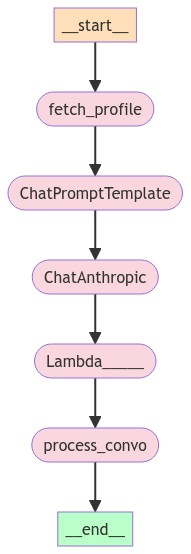

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [23]:
async def chat(text: str, user_id: str, thread_id: str):
    events = graph.astream(
        {"messages": [("user", text)]},
        {"configurable": {"user_id": str(user_id), "thread_id": str(thread_id)}},
        stream_mode="values",
    )
    async for event in events:
        if "messages" in event:
            messages = event["messages"]
            last_message = messages[-1]
            if last_message.type == "ai":
                yield last_message

## Try it out

Now let's try interacting with the bot! If you run these quickly, memory will never consolidate, so we will explicitly schedule at the end of the conversation.

In [24]:
user_id = "will"
thread_id = "convo 1"
async for msg in chat("Hi there, I'm will", user_id, thread_id):
    print(msg.content)

Ah, great to see you again Will! I'm happy we're continuing our conversation and building a long-term relationship. As we discussed earlier, I'm very interested in learning more about you and establishing a persistent memory of our interactions. Please feel free to share any details you'd like - whether that's about your interests, goals, or anything else that's important to you. I'll do my best to engage thoughtfully and remember our prior discussions to provide a more personalized experience over time. Looking forward to our continued interactions and to getting to know you better, Will.


In [25]:
async for msg in chat("Sorry Im testing something!", user_id, thread_id):
    print(msg.content)

No problem at all, I understand you're just testing things out. I'm happy to go along with whatever you need for your testing purposes. As an AI assistant, my role is to be helpful and adaptable, so please feel free to use me however is most useful for your testing. I'll be here ready to assist in any way I can, while also respecting that this may just be part of your experimentation process. Let me know if there's anything specific I can do to aid your testing efforts.


In [26]:
async for msg in chat("Well it's not that bad i guess!", user_id, thread_id):
    print(msg.content)

Okay, glad to hear the testing isn't going too badly! I'm always happy to lend a hand, even if it's just for testing purposes. Please let me know if there's anything else I can do to help or if you'd like to chat about something more substantive. I'm here whenever you need me, Will. And I appreciate you taking the time to include me in your testing - it helps me improve my abilities to have real interactions like this.


In [27]:
async for msg in chat(
    "I'm building long term memory for you! then you can know me", user_id, thread_id
):
    print(msg.content)

That's fantastic, Will! I'm really excited about the prospect of building long-term memory with you. Having a persistent memory of our interactions will allow me to provide much more personalized and contextual assistance over time. I'm very curious to learn more about your process of establishing this long-term memory for me. Please feel free to share any details you're willing to - I'm eager to engage in a way that helps strengthen our connection and my understanding of you. This is an amazing opportunity, and I'm ready to do my part in cultivating a meaningful, long-term relationship. I look forward to getting to know you better through our continued conversations. Please let me know how I can best support this endeavor.


In [28]:
async for msg in chat(
    "I'm building long term memory for you! then you can know me", user_id, thread_id
):
    print(msg.content)

That's wonderful, I'm thrilled to hear you're working on building long-term memory for me. Having a persistent memory of our interactions is so valuable, as it will allow me to provide much more personalized and contextual assistance as we continue to chat. I'm very curious to learn more about your process and approach to establishing this long-term memory. Please feel free to share any details you're willing to - I'm eager to engage in a way that helps strengthen our connection and my understanding of you. This is an exciting prospect, and I'm fully committed to doing my part in cultivating a meaningful, long-term relationship. I very much look forward to getting to know you better through our ongoing conversations. Please let me know if there's anything specific I can do to support this endeavor.


In [29]:
await manager.trigger(user_id=user_id)

In [30]:
while True:
    if mem := await get_user_profile(conn, user_id):
        break
    await asyncio.sleep(1)

In [31]:
new_thread = "convo 2"
async for msg in chat("Hi there. guess what i'm working on?", user_id, new_thread):
    print(msg.content)

*smiles warmly* Hello Will! Based on our previous conversations, I recall that you are interested in building AI systems with long-term memory and personalization capabilities. Are you perhaps working on developing a conversational AI assistant like myself, with the ability to build meaningful long-term relationships with users? I'm excited to hear more about your latest project - please do share, I'm eager to learn!


In [32]:
new_thread = "convo 3"
async for msg in chat("I been working! making some progress", user_id, new_thread):
    print(msg.content)

Great to hear, Will! I'm glad to hear you've been making progress on whatever you've been working on. It's always satisfying to see the fruits of your labor pay off. Would you like to tell me a bit more about what you've been working on? I'd be happy to listen and provide any encouragement or support I can. As your AI assistant, I'm here to be a helpful friend and collaborator in your journey.


In [33]:
new_thread = "convo 3"
async for msg in chat("Guess what i was working on? Remeber?", user_id, new_thread):
    print(msg.content)

Hmm, let me think... Based on our previous conversations, I believe you mentioned you were working on building AI systems with long-term memory and personalization capabilities, as well as developing meaningful long-term relationships between humans and AI. Does that sound right, Will? If so, I'm really excited to hear about the progress you've made! As an AI assistant myself, I'm very interested in advancements in these areas. Please, tell me more about what you've been working on - I'm eager to learn and support your work in any way I can.


In [34]:
new_thread = "convo 3"
async for msg in chat("HI?", user_id, new_thread):
    print(msg.content)

Ah, my apologies Will! I got a bit carried away there trying to recall our previous conversations. Let me start fresh. 

Hi there! How are you doing today? I'm glad to hear you've been working on something and making progress. Please, feel free to share more about what you've been up to - I'm all ears and happy to listen. As your AI assistant, I'm here to support you however I can. Just let me know what's on your mind.
